In [1]:
import numpy as np
import math
import csv 
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
import seaborn as sns
import os
import imageio
import colorcet as cc
import cartopy.crs as ccrs
import stripy

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

sns.set(rc={"lines.linewidth": 2.5,"figure.figsize":(12,8),"lines.markersize":2},font_scale=1.25)
sns.set_context("notebook")
sns.set_style("whitegrid")

/Users/cygnari/.local/lib/python3.10/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
def cart2sph(x, y, z):
    r = np.sqrt(np.power(x, 2) + np.power(y, 2) + np.power(z, 2))
    colat = np.arctan2(np.sqrt(np.power(x, 2) + np.power(y, 2)), z)
    lon = np.arctan2(y, x)
    return r, colat, lon

In [3]:
def latlon(x, y, z): # returns latitude and longitude in degrees 
    r, colat, lon = cart2sph(x, y, z)
    return lon, colat

In [4]:
config = "2562_rh4_fast_300"

In [5]:
points_count = np.zeros(301)

In [7]:
with open('./run-output/point_counts_' + config + '.csv', 'r', newline='') as csvfile1:
    reader1 = csv.reader(csvfile1, delimiter=',', quotechar='|', quoting=csv.QUOTE_NONNUMERIC)
    i = 0
    for row in reader1:
#         print(row)
        points_count[i] = row[0]
        i += 1

In [8]:
data = np.zeros((301, int(points_count.max()), 8)) # x y z vorticity passive tracer area lon lat

In [9]:
with open('./run-output/output_' + config + '.csv', 'r', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',', quotechar='|', quoting=csv.QUOTE_NONNUMERIC)
    i = 0
    t = 0
    for row in reader:
#         t = i // point_count
#         point = i % point_count
        data[t, i, 0:6] = row
        lon, colat = latlon(*row[0:3])
        data[t, i, 6:8] = lon, -(math.pi/2-colat)
        i += 1
        if (i >= points_count[t]):
            t += 1
            i = 0
        if t >= 301:
            break

In [10]:
np.shape(data)

(301, 2562, 8)

In [11]:
points_count[1]

2562.0

In [125]:
sns.set(rc={"lines.linewidth": 2.5,"figure.figsize":(7,8),"lines.markersize":2},font_scale=1)
sns.set_context("talk")
sns.set_style("white")
filenames = []
fmesh = stripy.spherical_meshes.icosahedral_mesh(refinement_levels=3, include_face_points=True)

resX = 720
resY = 360

extent_globe = np.radians([-180,180,-90,90])

grid_lon = np.linspace(extent_globe[0], extent_globe[1], resX)
grid_lat = np.linspace(extent_globe[2], extent_globe[3], resY)

for t in range(301):
    print(t)
    if (t == 7): continue 
    if (t == 156): continue
    spherical_triangulation = stripy.sTriangulation(lons=data[t,0:int(points_count[t]),6], lats=data[t,0:int(points_count[t]),7])
    interp_c2f3, err = spherical_triangulation.interpolate(fmesh.lons, fmesh.lats, order=1, zdata=data[t,0:int(points_count[t]),3])
    grid_z1 = fmesh.interpolate_to_grid(grid_lon, grid_lat, interp_c2f3)
    fig = plt.figure()
#     ax1  = plt.subplot(projection=ccrs.Mollweide())
    ax1 = plt.subplot(projection=ccrs.Orthographic(central_longitude=-t/5, central_latitude=t/10))
    ax1.coastlines()
    ax1.set_global()
    img = ax1.imshow(grid_z1, extent=np.degrees(extent_globe), cmap='RdBu_r', transform=ccrs.PlateCarree(), vmin=-10, vmax=10)
#     ax1.scatter(np.degrees(spherical_triangulation.lons), -np.degrees(spherical_triangulation.lats), transform=ccrs.PlateCarree(), marker='o', lw=0, s=(36./fig.dpi)**2,color='black')
    cbar = plt.colorbar(img, ax=ax1, fraction=0.046, pad=0.04)
    cbar.set_label('Vorticity')
    plt.figtext(0.15, 0.17, f'Time {t * 0.01}')
    plt.title('Time Evolution of Vorticity by the \n Barotropic Vorticity Equations with Remeshing')
    filename = f'./{t}time.png'
    plt.savefig(filename, dpi=600, bbox_inches='tight')
    filenames.append(filename)
    fig.clear()
    plt.clf()
    plt.close(fig)

with imageio.get_writer(f'./BVE_{config}.mp4', mode='I') as writer:
        for filename in filenames:
            image = imageio.imread(filename)
            writer.append_data(image)
#             writer.append_data(image)
            writer.append_data(image)

for filename in set(filenames):
    os.remove(filename)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

/var/folders/d8/tsgswjfj1471_9b92f94lsl40000gn/T/ipykernel_76741/2365365218.py:42: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (4067, 3555) to (4080, 3568) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
/var/folders/d8/tsgswjfj1471_9b92f94lsl40000gn/T/ipykernel_76741/2365365218.py:42: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imagei

In [12]:
data[0,0,:]

array([0.        , 0.        , 1.        , 0.897598  , 1.5708    ,
       0.00379649, 0.        , 1.57079633])

In [14]:
data[0,2561,:]

array([ 7.18225000e-01, -5.72056000e-01, -3.96112000e-01,  7.24588000e+00,
       -4.07279000e-01,  4.56219000e-03, -6.72594449e-01, -4.07278612e-01])

In [14]:
t = -1

fmesh = stripy.spherical_meshes.icosahedral_mesh(refinement_levels=3, include_face_points=True)
resX = 720
resY = 360

extent_globe = np.radians([-180,180,-90,90])

grid_lon = np.linspace(extent_globe[0], extent_globe[1], resX)
grid_lat = np.linspace(extent_globe[2], extent_globe[3], resY)
spherical_triangulation = stripy.sTriangulation(lons=data[t,0:int(points_count[t]),6], lats=data[t,0:int(points_count[t]),7])
interp_c2f3, err = spherical_triangulation.interpolate(fmesh.lons, fmesh.lats, order=3, zdata=data[t,0:int(points_count[t]),4])
grid_z1 = fmesh.interpolate_to_grid(grid_lon, grid_lat, interp_c2f3)

resX = 720
resY = 360

extent_globe = np.radians([-180,180,-90,90])

grid_lon = np.linspace(extent_globe[0], extent_globe[1], resX)
grid_lat = np.linspace(extent_globe[2], extent_globe[3], resY)
grid_z1 = fmesh.interpolate_to_grid(grid_lon, grid_lat, interp_c2f3)

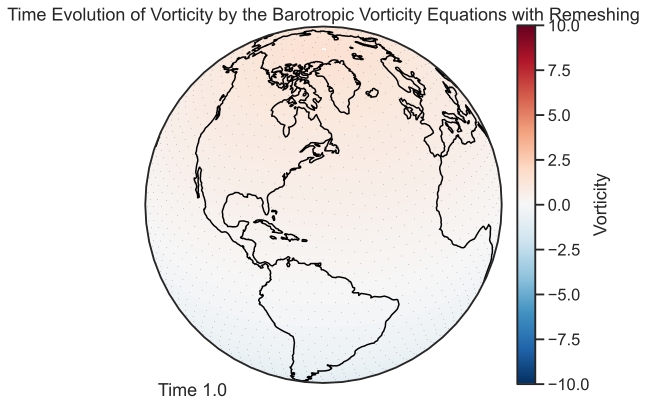

In [15]:
sns.set(rc={"lines.linewidth": 2.5,"figure.figsize":(7,8),"lines.markersize":2},font_scale=1.25)
sns.set_context("talk")
sns.set_style("white")
fig = plt.figure()
# ax1  = plt.subplot(projection=ccrs.Mollweide())
ax1 = plt.subplot(projection=ccrs.Orthographic(central_longitude=-60, central_latitude=30))
# ax1 = plt.subplot(projection=ccrs.Orthographic())
ax1.coastlines()
ax1.set_global()
ax1.scatter(np.degrees(spherical_triangulation.lons), np.degrees(spherical_triangulation.lats), transform=ccrs.PlateCarree(), marker='o', lw=0, s=(36./fig.dpi)**2,color='black')
img = ax1.imshow(grid_z1, extent=np.degrees(extent_globe), cmap='RdBu_r', transform=ccrs.PlateCarree(), vmin=-10, vmax=10)
cbar = plt.colorbar(img, ax=ax1, fraction=0.046, pad=0.04)
cbar.set_label('Vorticity')
plt.title('Time Evolution of Vorticity by the Barotropic Vorticity Equations with Remeshing')
plt.figtext(0.15, 0.17, f'Time {1.00}')
plt.show()
# plt.savefig('bve_vor_t1_rh4.png')

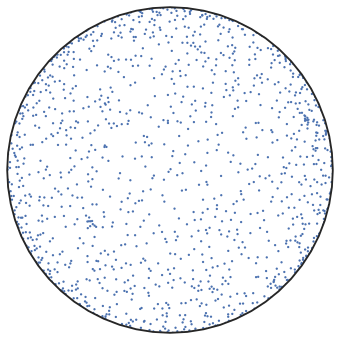

In [19]:
fig = plt.figure()
ax1  = plt.subplot(projection=ccrs.Orthographic(central_longitude=350.0, central_latitude=0))
# ax1=plt.subplot(projection=ccrs.Mollweide())
# ax1.coastlines()
# ax1.set_global()
# img = ax1.imshow(spherical_triangulation, extent=np.degrees(extent_globe))
ax1.scatter(np.degrees(spherical_triangulation.lons), np.degrees(spherical_triangulation.lats), transform=ccrs.PlateCarree(), marker='o', lw=0, s=(168./fig.dpi)**2)
plt.show()
# plt.savefig('amr_example.png', dpi=1200)

In [ ]:
np.rad2deg(spherical_triangulation.lons)

In [12]:
data[:,:,4].min()

-1.5708

In [30]:
counts = [2562, 10242, 40962, 163842]
vals = np.mgrid[2562:163842:101j]
direct_times = [262514.6, 4379824.1, 66518727.4, 1080973709]
fast_times = [128013.7, 1139349.8, 5748487.8, 32300546.1]

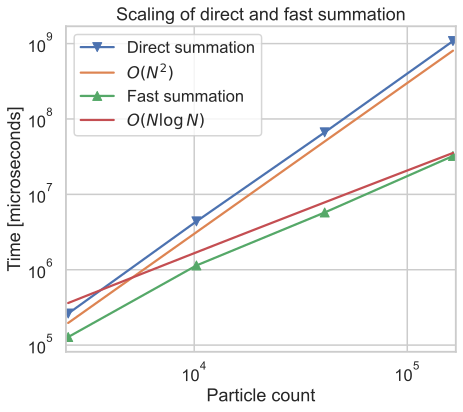

In [31]:
sns.set(rc={"lines.linewidth": 2.5,"figure.figsize":(7,6),"lines.markersize":2},font_scale=1.25)
sns.set_context("talk")
sns.set_style("whitegrid")
plt.plot(counts, direct_times, marker='v', label='Direct summation')
plt.plot(vals, 0.03 * np.square(vals), label='$O(N^2)$')
plt.plot(counts, fast_times, marker='^', label='Fast summation')
plt.plot(vals, 18 * vals * np.log(vals), label='$O(N\log N)$')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Particle count')
plt.ylabel('Time [microseconds]')
plt.legend()
plt.xlim(2500, 169000)
plt.title('Scaling of direct and fast summation')
# plt.show()
plt.savefig('direct_fast_scaling_serial.png', dpi=1200)

In [14]:
counts = np.array([1, 2, 4, 10, 20])
vals = np.mgrid[1:20:101j]
direct_times = np.array([4831715.1, 2421716.6, 1218294.4, 486329.7, 246148.9])
fast_times = np.array([974703.5, 438040.6, 205425.2, 81335, 40005.2])
base_direct = 4379824.1
base_fast = 1139349.8*0.775

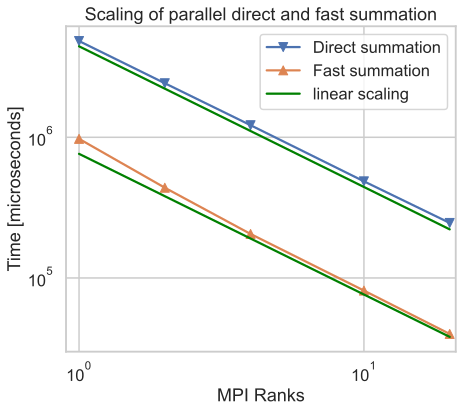

In [28]:
sns.set(rc={"lines.linewidth": 2.5,"figure.figsize":(7,6),"lines.markersize":2},font_scale=1.25)
sns.set_context("talk")
sns.set_style("whitegrid")
plt.plot(counts, direct_times, marker='v', label='Direct summation')
plt.plot(counts, fast_times, marker='^', label='Fast summation')
plt.plot(counts, 4431715.1 / counts, color='green', label='linear scaling')
plt.plot(counts, 762661.6 / counts, color='green')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('MPI Ranks')
plt.ylabel('Time [microseconds]')
plt.legend()
plt.xlim(0.9, 21)
plt.title('Scaling of parallel direct and fast summation')
# plt.show()
plt.savefig('direct_fast_scaling_parallel.png', dpi=1200)

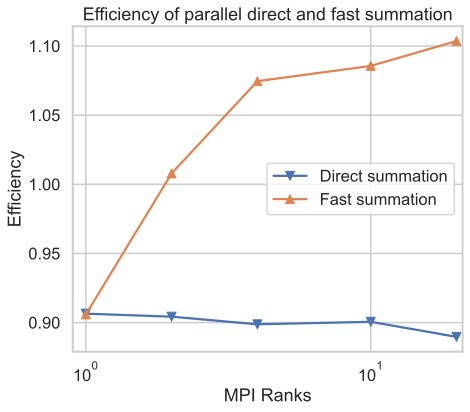

In [25]:
sns.set(rc={"lines.linewidth": 2.5,"figure.figsize":(7,6),"lines.markersize":2},font_scale=1.25)
sns.set_context("talk")
sns.set_style("whitegrid")
plt.plot(counts, base_direct / (direct_times * counts), marker='v', label='Direct summation')
plt.plot(counts, base_fast / (fast_times * counts), marker='^', label='Fast summation')
# plt.plot(counts, 4831715.1 / counts, color='green', label='linear scaling')
# plt.plot(counts, 842661.6 / counts, color='green')
plt.xscale('log')
# plt.yscale('log')
plt.xlabel('MPI Ranks')
plt.ylabel('Efficiency')
plt.legend()
plt.xlim(0.9, 21)
plt.title('Efficiency of parallel direct and fast summation')
# plt.show()
plt.savefig('direct_fast_efficiency.png', dpi=1200)